# Imports

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib
from matplotlib import cm
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import pickle

from sklearn.preprocessing import binarize
import sklearn.metrics as met
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

matplotlib.style.use('ggplot')
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

In [2]:
###### DO NOT MODIFY THIS FUNCTION #####
def tokenize_doc(doc):
    """
    Tokenize a document and return its bag-of-words representation.
    doc - a string representing a document.
    returns a dictionary mapping each word to the number of times it appears in doc.
    """
    bow = defaultdict(float)
    tokens = doc.split()
    lowered_tokens = map(lambda t: t.lower(), tokens)
    for token in lowered_tokens:
        bow[token] += 1.0
    return dict(bow)
###### END FUNCTION #####

## Retrieve Data

In [3]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

/Users/Jojo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Exploration

In [4]:
train_data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [5]:
train_data.head(30)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


# Baseline model

In [6]:
# feature: words per question

def count_words(question):
    question = str(question)
    words = question.split()
    return len(words)

train_data["q1l"] = train_data["question1"].apply(count_words)
train_data["q2l"] = train_data["question2"].apply(count_words)
test_data["q1l"] = test_data["question1"].apply(count_words)
test_data["q2l"] = test_data["question2"].apply(count_words)

In [7]:
# feature: repeated words per question

def count_repeats(row):
    q1 = str(row['question1']).lower()
    q2 = str(row['question2']).lower()
    
    w1 = q1.split()
    w2 = q2.split()
    
    count = 0
    
    if len(w1) > len(w2):
        for word in w1:
            if word in w2:
                count = count + 1
    else:
        for word in w2:
            if word in w1:
                count = count + 1
    
    return count

train_data["repeats"] = train_data.apply(count_repeats, axis=1)
test_data["repeats"] = test_data.apply(count_repeats, axis=1)

##### Initial Test

In [8]:
tp = 0
tn = 0
fp = 0
fn = 0

for index, row in train_data.iterrows():
    if (row['repeats']/row['q1l'] + row['repeats']/row['q2l'])/2 >= 0.5:
        if row['is_duplicate'] == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if row['is_duplicate'] == 1:
            fn = fn + 1
        else:
            tn = tn + 1

In [9]:
print("Accuracy: ", (tp+tn)/(tp+tn+fp+fn))
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives: ", tp)
print("True negatives: ", tn)

Accuracy:  0.6695490860520913
False positives:  87292
False negatives:  46306
True positives:  102957
True negatives:  167735


#### Results Visualization

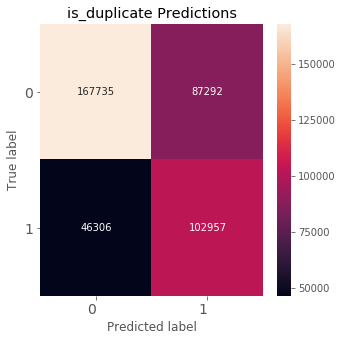

In [10]:
plt.figure(figsize=[5,5])
heatmap = sb.heatmap([[tn,fp],[fn,tp]], annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("is_duplicate Predictions")
plt.show()

##### Test with equal sample size

In [11]:
g = train_data.groupby('is_duplicate')
g = g.apply(lambda x: x.sample(g.size().min()))
g

id    qid1    qid2  \
is_duplicate                                  
0            329922  329922  456616  307018   
             289830  289830  411010  411011   
             128335  128335  206419  206420   
             271510  271510  389606  389607   
             1392      1392    2774    2775   
             356202  356202  485486  485487   
             135929  135929  216987  216988   
             236618  236618  347584  339893   
             205705  205705  308938  308939   
             203217  203217  305769  305770   
             63845    63845  111037  111038   
             264048  264048  380727  380728   
             31746    31746   58509   58510   
             73389    73389  125937  125938   
             246233  246233  359251  359252   
             388251  388251  164922  520625   
             101205  101205  167710  167711   
             226103  226103  181354  334638   
             399059  399059  532306   35899   
             13762    13762   26396   26397   
             43420    43420   78103   78104   
             359259  359259  488883  488884   
             53015    53015   93784   93785   
             110728  110728  181492  181493   
             9862      9862   19152   19153   
             196624  196624  297366  297367   
             275885  275885  394742  394743   
             390211  390211  522717  522718   
             12726    12726   24496   24497   
             57572    57572  101146  101147   
...                     ...     ...     ...   
1            126599  126599  142276  203972   
             189278  189278    5051   21280   
             378493  378493  509893  509894   
             391854  391854  327772  352476   
             32757    32757   60261   60262   
             113587  113587   65309  185594   
             120860  120860   28116   79892   
             363175  363175  493134  493135   
             262066  262066   88908   18157   
             42536    42536   76636   76637   
             186849  186849    5745   10473   
             67870    67870  117386  117387   
             236788  236788   15273   51281   
             29654    29654   44200   54842   
             266665  266665  383874  383875   
             179296  179296  171701  275146   
             13867    13867   26595   26596   
             158579  158579   29876   38504   
             289916  289916  411106  411107   
             171069  171069   11564  264410   
             148608  148608   57490   81822   
             257101  257101  372357  372358   
             361492  361492    4629    9421   
             298706  298706  139762  129523   
             118672  118672  192832   66164   
             169626  169626  169217  262449   
             244423  244423  203223  173210   
             242250  242250  123740   70435   
             125410  125410   63316   21549   
             124673  124673   13749   83010   

                                                             question1  \
is_duplicate                                                             
0            329922                      How can I do the right thing?   
             289830  What do different lines and colors on the road...   
             128335  What is the work that is assigned to a GIS pro...   
             271510  My piano teacher asked me if I'd like to take ...   
             1392    Is downloading iTunes music onto a flashdrive ...   
             356202  Do you know anyone using pure VoLTE in LG G4. ...   
             135929       What causes a diesel engine to stop running?   
             236618  What is the difference between quality control...   
             205705  How can I aim to become a data scientist from ...   
             203217  What is it that makes you catch a cold when yo...   
             63845   What is the reason for there being major oil d...   
             264048                           Is console gaming dying?   
             31746        H

In [49]:
trp = 0
trn = 0
fap = 0
fan = 0
a = 0
b = 0

for i, row in g.iterrows():
    if (row['repeats']/row['q1l'] + row['repeats']/row['q2l'])/2 >= 0.43:
        if row['is_duplicate'] == 1:
            trp = trp + 1
        else:
            if abs(row['q1l'] - row['q2l']) > 10 and b == 0:
                b = 1
                print('fap')
                print(row['question1'])
                print(row['question2'])
                print(" ")
            if fap == 0:
                print("False Positives:")
            fap = fap + 1
            if fap < 15:
                print(row['question1'])
                print(row['question2'])
                print(" ")
    else:
        if row['is_duplicate'] == 1:
            if abs(row['q1l'] - row['q2l']) > 10 and a == 0:
                a = 1
                print('fan')
                print(row['question1'])
                print(row['question2'])
                print(" ")
            if fan == 0:
                print("False Negatives:")
            fan = fan + 1
            if fan < 15:
                print(row['question1'])
                print(row['question2'])
                print(" ")
        else:
            trn = trn + 1

False Positives:
How can I do the right thing?
Why do I always do the right thing?
 
What causes a diesel engine to stop running?
How to bleed a diesel engine?
 
What is the difference between quality control and quality assurance?
What is the difference between quality assurance, quality control and testing?
 
What is the reason for there being major oil deposits in Arab countries?
What are the reasons for the USA to invade/attack some of the Arab countries?
 
Can you get US work visa with only masters degree but not bachelors?
If you get a bachelors degree in social work can you go on to become a therapist when you get your masters?
 
What is the temperament of a German Shepherd/Golden Retriever/Husky mix?
What is the temperament of a golden shepherd (golden retriever/German shepherd mix)?
 
What can one do to help enrich, contribute, and improve the Philippines and the Filipino culture?
What do people from other countries hate the most about Filipino culture?
 
What do Cambodians an

In [50]:
print("Accuracy: ", (trp+trn)/(trp+trn+fap+fan))
print("False positives: ", fap)
print("False negatives: ", fan)
print("True positives: ", trp)
print("True negatives: ", trn)

Accuracy:  0.6874778076281463
False positives:  62344
False negatives:  30952
True positives:  118311
True negatives:  86919


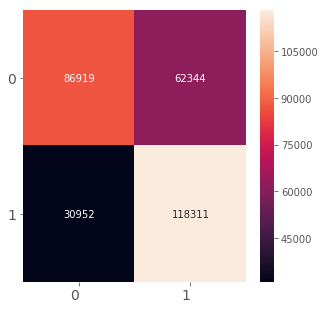

In [51]:
plt.figure(figsize=[5,5])
heatmap2 = sb.heatmap([[trn,fap],[fan,trp]], annot=True, fmt="d")
heatmap2.yaxis.set_ticklabels(heatmap2.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap2.xaxis.set_ticklabels(heatmap2.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.title("is_duplicate Predictions")
plt.show();

### Ready train/validation

In [15]:
features = ["repeats", "q1l", "q2l"]

X = train_data[features]
y = train_data["is_duplicate"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33)

### Random Forest Classifier

0.6963032919589854


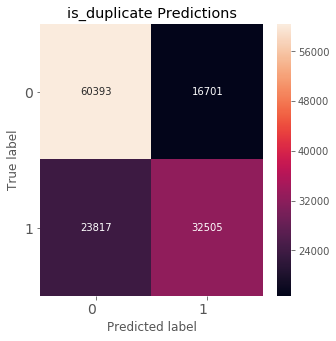

In [16]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_val)
rfc_cm = confusion_matrix(rfc_predict, y_val)
print(accuracy_score(rfc_predict, y_val))

plt.figure(figsize=[5,5])
heatmap = sb.heatmap(rfc_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("is_duplicate Predictions")
plt.show();

## Data Visualization

In [17]:
print(len(train_data[train_data['is_duplicate'] == 1]))
print(len(train_data[train_data['is_duplicate'] == 0]))
print(len(train_data))
print(len(test_data))

149263
255027
404290
3563475


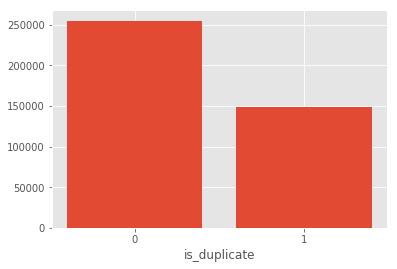

In [18]:
not_dup = len(train_data[train_data['is_duplicate'] == 0])
dup = len(train_data[train_data['is_duplicate'] == 1])
          
plt.figure()
plt.bar([1,2], [not_dup, dup], align="center")
plt.xlabel("is_duplicate")
plt.xticks([1,2], ["0", "1"])
# plt.title("Number of Duplicate vs. Non-Duplicate Questions")
plt.show();

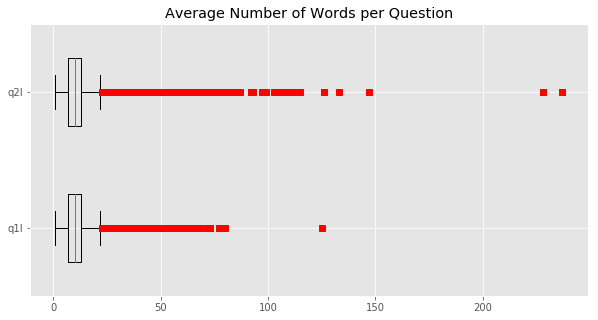

In [19]:
data = [train_data['q1l'], train_data['q2l']]

plt.figure(figsize=[10,5])
plt.boxplot(data, 0, 'rs', 0, widths=[0.5,0.5])
plt.yticks([1,2],["q1l", "q2l"])
plt.title("Average Number of Words per Question")
plt.show();

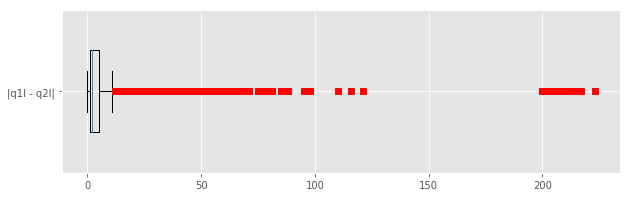

In [20]:
data = abs(train_data['q1l'] - train_data['q2l'])

plt.figure(figsize=[10,3])
plt.boxplot(data, 0, 'rs', 0, widths=[0.5])
plt.yticks([1],["|q1l - q2l|"])
# plt.title("Question 1 and Question 2 Difference in Length")
plt.show();

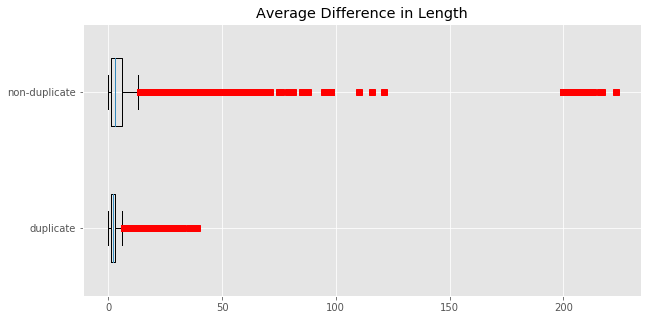

In [21]:
data1 = abs(train_data[train_data['is_duplicate'] == 1]['q1l'] - train_data[train_data['is_duplicate'] == 1]['q2l'])
data2 = abs(train_data[train_data['is_duplicate'] == 0]['q1l'] - train_data[train_data['is_duplicate'] == 0]['q2l'])
data3 = [data1, data2]

plt.figure(figsize=[10,5])
plt.boxplot(data3, 0, 'rs', 0, widths=[0.5,0.5])
plt.yticks([1,2],["duplicate", "non-duplicate"])
plt.title("Average Difference in Length")
plt.show();

In [22]:
duplicate_counts = Counter()
nonduplicate_counts = Counter()

for i, row in g.iterrows():
    question = str(row['question1']) + " " + str(row['question2'])
    if row['is_duplicate'] == 1:
        duplicate_counts.update(tokenize_doc(question))
    else:
        nonduplicate_counts.update(tokenize_doc(question))

In [23]:
nonduplicate_counts = sorted(nonduplicate_counts.items(), key=lambda x: x[1], reverse=True)
duplicate_counts = sorted(duplicate_counts.items(), key=lambda x: x[1], reverse=True)

In [24]:
count = 0
for i in nonduplicate_counts:
    if count == 30:
        break
    print("'" + str(i[0]) + "': " + str(i[1]))
    count = count + 1

'the': 142012.0
'what': 116205.0
'is': 104558.0
'a': 89895.0
'i': 81732.0
'in': 80367.0
'to': 80161.0
'how': 76096.0
'of': 62669.0
'do': 54685.0
'are': 54086.0
'and': 53436.0
'for': 41468.0
'can': 39383.0
'you': 30331.0
'why': 27107.0
'my': 26341.0
'it': 26064.0
'does': 23890.0
'on': 21883.0
'best': 20722.0
'or': 18869.0
'if': 17261.0
'have': 16509.0
'with': 16347.0
'an': 15895.0
'which': 15830.0
'be': 15684.0
'that': 15584.0
'some': 15326.0


In [25]:
count = 0
for i in duplicate_counts:
    if count == 30:
        break
    print("'" + str(i[0]) + "': " + str(i[1]))
    count = count + 1

'the': 133151.0
'what': 112690.0
'is': 90574.0
'how': 89392.0
'i': 73033.0
'to': 66831.0
'do': 61216.0
'in': 57432.0
'a': 56366.0
'are': 52714.0
'of': 51833.0
'can': 46150.0
'and': 41618.0
'best': 34166.0
'you': 32825.0
'for': 30745.0
'why': 29011.0
'my': 25376.0
'on': 21929.0
'which': 16718.0
'it': 16022.0
'be': 15607.0
'your': 15570.0
'does': 15481.0
'some': 15433.0
'get': 14515.0
'if': 13761.0
'should': 12795.0
'will': 12654.0
'that': 12420.0


In [26]:
thing1 = (train_data[train_data['is_duplicate'] == 0]['repeats']/train_data[train_data['is_duplicate'] == 0]['q1l'] + train_data[train_data['is_duplicate'] == 0]['repeats']/train_data[train_data['is_duplicate'] == 0]['q2l'])/2
thing2 = (train_data[train_data['is_duplicate'] == 1]['repeats']/train_data[train_data['is_duplicate'] == 1]['q1l'] + train_data[train_data['is_duplicate'] == 1]['repeats']/train_data[train_data['is_duplicate'] == 1]['q2l'])/2

/Users/Jojo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Jojo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


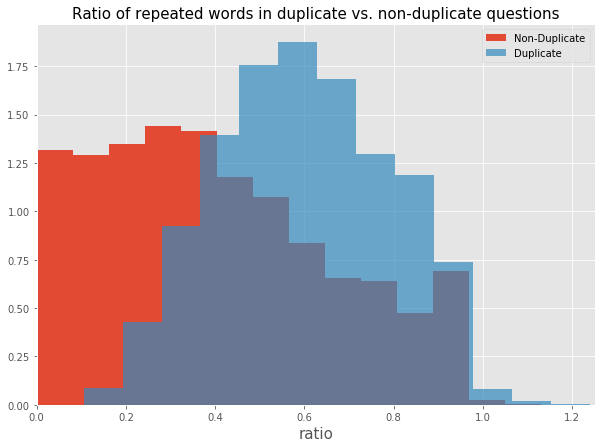

In [27]:
plt.figure(figsize=(10, 7))
plt.hist(thing1, bins=20, normed=True, label='Non-Duplicate')
plt.hist(thing2, bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Ratio of repeated words in duplicate vs. non-duplicate questions', fontsize=15)
plt.xlabel('ratio', fontsize=15)
plt.xlim(0,1.25)
plt.show();

# Compare to LSTM

In [28]:
with open('MaLSTM/precision.pkl', 'rb') as file1:
        precision_LSTM = pickle.load(file1)
with open('MaLSTM/recall.pkl', 'rb') as file2:
        recall_LSTM = pickle.load(file2)

In [29]:
preds = ((train_data['repeats']/train_data['q1l'] + train_data['repeats']/train_data['q2l'])/2).values.reshape(-1,1)
targets = (train_data['is_duplicate']).values.reshape(-1,1)

In [30]:
xp = list(_/1000 for _ in range(1000))
acc = []
f1 = []
pre = []
rec = []
for thresh in xp:
    x = binarize(preds, thresh, copy=True)
    f1.append(met.f1_score(targets, x))
    acc.append(met.accuracy_score(targets, x))
    pre.append(met.precision_score(targets, x))
    rec.append(met.recall_score(targets, x))

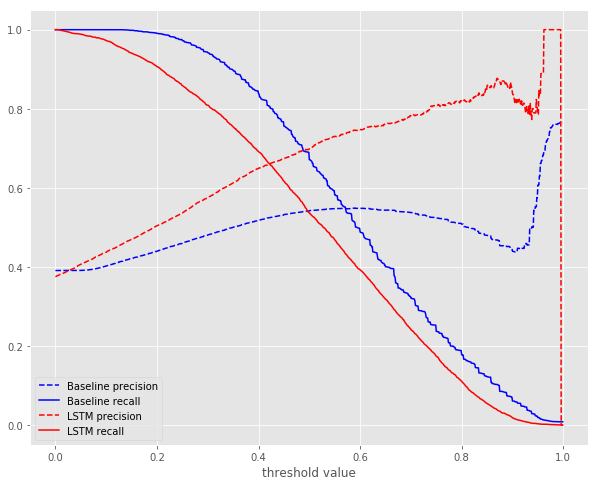

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(list(_/1000 for _ in range(1000)), pre, 'b--', label="Baseline precision")
plt.plot(list(_/1000 for _ in range(1000)), rec, 'b', label="Baseline recall")
plt.plot(list(_/1000 for _ in range(1000)), precision_LSTM, 'r--', label="LSTM precision")
plt.plot(list(_/1000 for _ in range(1000)), recall_LSTM, 'r', label="LSTM recall")
plt.legend()
plt.xlabel("threshold value")
plt.show();

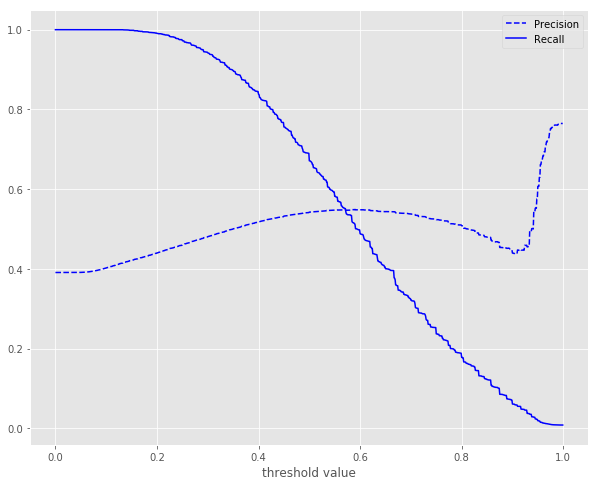

In [52]:
plt.figure(figsize=(10, 8))
plt.plot(list(_/1000 for _ in range(1000)), pre, 'b--', label="Precision")
plt.plot(list(_/1000 for _ in range(1000)), rec, 'b', label="Recall")
plt.legend()
plt.xlabel("threshold value")
plt.show();